In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from pa_lib.file import store_bin, project_dir, data_files, load_csv, load_bin, write_xlsx
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect
from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [2]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_labels = load_bin("ax_var_labels.feather")

var = Record(**{v: v for v in ax_data['Variable'].unique()})
stat = Record(**{s: s for s in ax_data['Station'].unique()})

2019-09-26 16:37:40 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
2019-09-26 16:37:40 [INFO] Finished loading binary file in 0.12s (0.27s CPU)
2019-09-26 16:37:40 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_labels.feather
2019-09-26 16:37:40 [INFO] Finished loading binary file in 0.0s (0.0s CPU)


In [3]:
def var_label(variable):
    return ax_var_labels.set_index("Variable").at[variable, "Label"]

In [4]:
weekday_order = ax_data.DayOfWeek.cat.categories.to_list()
timeSlot_order = ax_data.TimeSlot.cat.categories.to_list()

weekend_rows = ax_data.DayOfWeek.isin(["Saturday", "Sunday"])
ax_data_weekends = ax_data.loc[weekend_rows].pipe(clean_up_categoricals)
ax_data_workdays = ax_data.loc[~weekend_rows].pipe(clean_up_categoricals)

In [5]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/6172735,27,5.9 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/6172735,7,5.9 MB,"[Monday,Sunday]"
Time,category,0/6172735,96,5.9 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/6172735,117,5.9 MB,"[g_220,nat_ausland]"
Code,category,0/6172735,155,11.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/6172735,343130,47.1 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/6172735,1,5.9 MB,"[2019,2019]"
Month,category,0/6172735,4,5.9 MB,"[05,08]"
logValue,float64,0/6172735,343130,47.1 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,0/6172735,117,5.9 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


## Define code order, where necessary

In [6]:
var_code_order = {
    "md_agenatrep": {
        "14-29 Jahre": 1,
        "30-45 Jahre": 2,
        "46-60 Jahre": 3,
        "61+ Jahre": 4,
    },
    "md_bildung3": {
        "niedrig (kein Abschluss, obligat. Schule, HH-Lehrjahr, Handelsschule, Anlehre)": 1,
        "mittel (Diplommittelschule, allg. Schule, Berufslehre, Vollzeitberufsschule, Maturität, Lehrerseminar)": 2,
        "hoch (Universität, ETH, FH, PH, höhere Berufsausbildung)": 3,
    },
    "md_hhgr3": {"1 Person": 1, "2 Personen": 2, "3+ Personen": 3},
    "g_privatetrainuse": {
        "Nie": 1,
        "1-2 Mal jährlich": 2,
        "3-12 Mal jährlich": 3,
        "2-5 Mal pro Monat": 4,
        "6 Mal pro Monat oder häufiger": 5,
    },
    "md_203": {  # Bahnnutzung beruflich
        "Nie": 1,
        "Seltener": 2,
        "Etwa zu einem Viertel": 3,
        "Etwa zur Hälfte": 4,
        "Meistens": 5,
        "Immer": 6,
    },
    "g_220": {  # Autos im Haushalt
        "Keines": 1,
        "1 Auto": 2,
        "2 Autos": 3,
        "3 Autos": 4,
        "Mehr als 3 Autos": 5,
    },
    "md_410": {  # Internetnutzung
        "seltener": 1,
        "mehrmals pro Monat": 2,
        "einmal pro Woche": 3,
        "mehrmals pro Woche": 4,
        "täglich/fast täglich": 5,
    },
    # Div.Internet-Nutzungsarten (md_421 bis md_411)
    "md_421": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_419": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_417": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_416": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_415": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_414": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_413": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_412": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_411": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_early": {
        "Ich bin immer einer/eine der ersten, der/die neue Technologien und Geräte kauft resp. einsetzt.": 1,
        "Ich fange erst dann an, neue Technologien und Geräte zu verwenden, wenn ich weiss, welche Erfahrungen andere mit ihnen gemacht haben.": 2,
        "Ich übernehme neue Technologien und Geräte erst dann, wenn es für mich persönlich oder beruflich unerlässlich ist.": 3,
    },
    "md_tv": {"kein TV-Gerät": 1, "1 oder mehrere TV-Geräte": 2},
    "g_TvChannelsgroup": {
        "keine Sender": 1,
        "1-4 Sender": 2,
        "5-9 Sender": 3,
        "10++ Sender": 4,
    },
    "g_flug": {"keine Flüge": 1, "1 - 4 Flüge": 2, "5 - 9 Flüge": 3, "10++ Flüge": 4},
    "g_flugBusiness": {
        "keine Flüge": 1,
        "1 - 4 Flüge": 2,
        "5 - 9 Flüge": 3,
        "10++ Flüge": 4,
    },
    "md_ek": {
        "Keine Angabe": 0,
        "Weniger als 3'000 CHF": 1,
        "Zwischen 3'000 und 4'500 CHF": 2,
        "Zwischen 4'501 und 6'000 CHF": 3,
        "Zwischen 6'001 und 9'000 CHF": 4,
        "Zwischen 9'001 und 12'000 CHF": 5,
        "Mehr als 12'000 CHF": 6,
    },
    "md_hhverm": {
        "Keine Angabe": 0,
        "Weniger als CHF 50 000": 1,
        "Zwischen CHF 50 000 und CHF 100 000": 2,
        "Zwischen CHF 100 000 und CHF 250 000": 3,
        "Zwischen CHF 250 000 und CHF 500 000": 4,
        "Zwischen CHF 500 000 und CHF 1 Mio.": 5,
        "Zwischen CHF 1 Mio. und CHF 5 Mio.": 6,
        "Mehr als CHF 5 Mio.": 7,
    },
}

# Check distributions

## Time

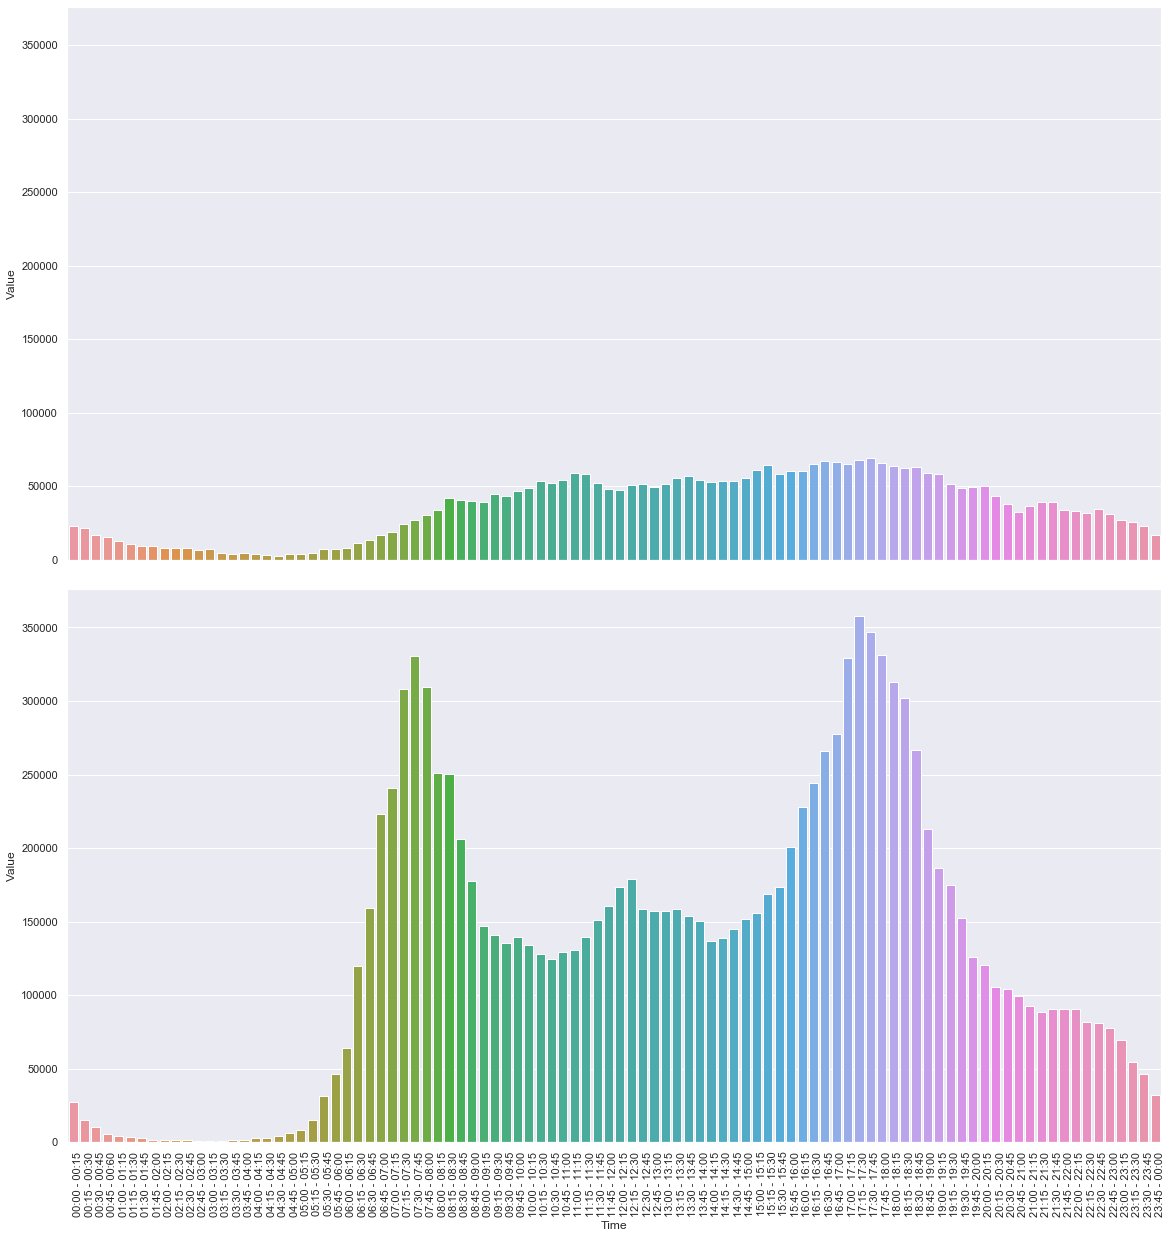

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays,
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends, x="Time", y="Value", ci=None, estimator=np.sum, ax=ax_weekend
)
fig.autofmt_xdate(rotation=90, ha='left')

### Time by Weekday

In [ ]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Time Slots

In [8]:
ax_data["TimeSlot"].value_counts()

Abend          1311431
Abend-Rush     1239244
Nachmittag     1050223
Morgen          903125
Morgen-Rush     812286
Nacht           502280
Mittag          354146
Name: TimeSlot, dtype: int64

### Plot sum(value) per time slot, scaled to one day

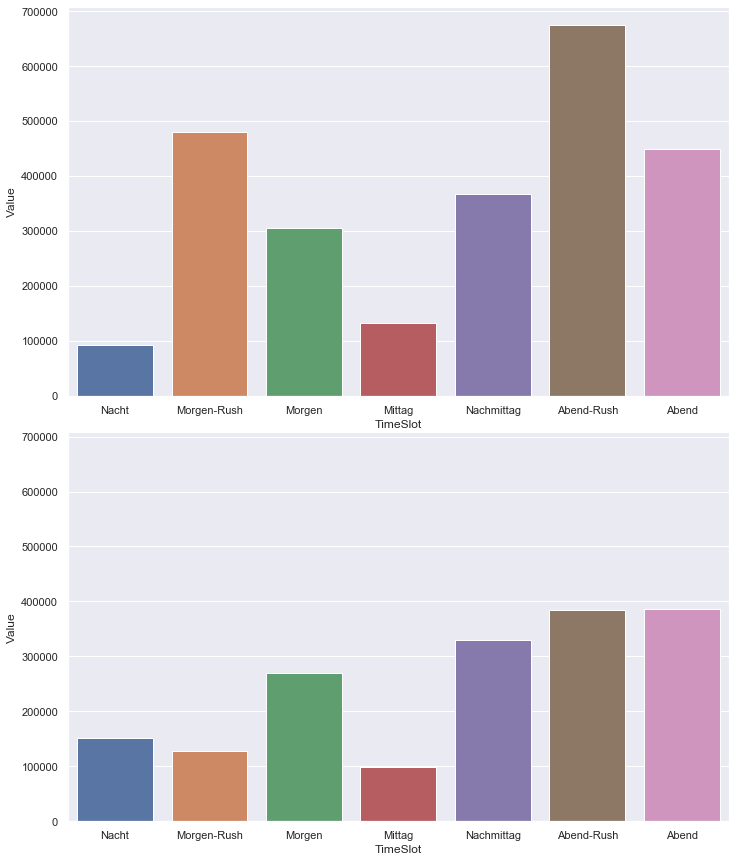

In [9]:
fig, (ax_workdays, ax_weekend) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(10, 12)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)

## Stations

In [ ]:
ax_data.Station.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

## Weekdays

In [ ]:
ax_data.DayOfWeek.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

# Tests for Independence

In [ ]:
from scipy.stats import chi2_contingency

def table_stats(variable, factor, partitions):
    data = ax_data.loc[ax_data.Variable == variable]
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, subset in data.groupby(partitions):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = subset.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result

## For all variables, find stations where the distribution of codes is dependent on day time

In [ ]:
%%time
factor = "Time"
partitions = ["Station"]

all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
for v in var:
    var_assoc = (table_stats(v, factor=factor, partitions=partitions)
                 .query(f"p_{factor} <= 0.05"))
    all_var_assoc = all_var_assoc.append(
        var_assoc, ignore_index=True, sort=False
    )

all_var_assoc["VarDesc"] = lookup(
    ax_var_labels, 
    target_col_name="Label", 
    match_col=all_var_assoc["Var"], 
    target_match_col_name="Variable",
)

In [ ]:
var_stations = pd.crosstab(
    index=all_var_assoc.VarDesc, columns=all_var_assoc.Label, margins=True
)

In [ ]:
with project_dir("axinova"):
    write_xlsx(var_stations, "var_by_station.xlsx", "contigency tab")

### Which variables have the most stations where their codes are time-dependent?

In [ ]:
all_var_assoc.groupby("Var", as_index=False).agg(
    {"VarDesc": "max", "Label": ["count", collect]}
).set_axis(
    ["Variable", "VarDesc", "#", "Stations"], axis="columns", inplace=False
).sort_values(
    "#", ascending=False
).reset_index(drop=True)

### Which stations have the most variables whose codes are time-dependent?

In [ ]:
all_var_assoc.groupby("Label").agg({"Var": "size"}).sort_values(
    "Var", ascending=False
)

## For a single variable, show distribution of codes over time

In [10]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)

time_order = {"DayOfWeek": weekday_order, "TimeSlot": timeSlot_order}

def plot_var_time_dist(data, variable, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @variable")
        .pipe(clean_up_categoricals)
        .copy()
    )
    codes_sorted = variable in var_code_order
    if codes_sorted:
        subset["Code_order"] = subset["Code"].replace(var_code_order[variable])
        code_list_sorted = list(var_code_order[variable])
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(
                over,
                sort=time_order.get(over, "ascending"),
            ),
            color=alt.Color(
                "Code",
                sort=code_list_sorted if codes_sorted else "ascending",
                scale=alt.Scale(scheme="spectral" if codes_sorted else "category20"),
            ),
            order=alt.Order("Code_order") if codes_sorted else alt.Order("Code"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(variable)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

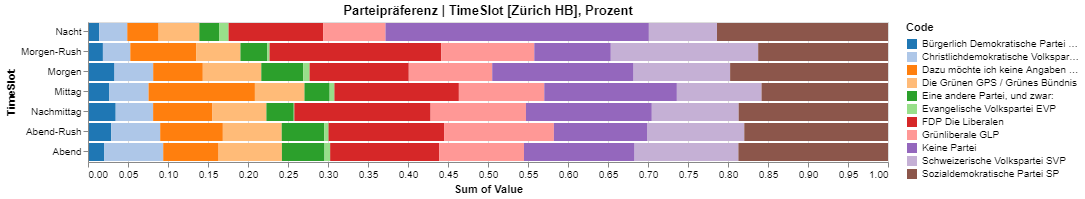

In [15]:
plot_var_time_dist(
    data=ax_data_workdays,
    variable=var.md_880,
    over="TimeSlot",
    station="Zürich HB",
    as_percent=True,
)

# ANOVA

In [16]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [48]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def calc_anova(data, variable, formula='logValue ~ Code + Station + DayOfWeek'):
    subset = data.loc[data.Variable==variable].pipe(clean_up_categoricals)
    subset = subset.assign(label=subset.Station.str.cat([subset.DayOfWeek.str[:3], subset.Code], sep='|'))
    subset.set_index('label', inplace=True)
    mod = smf.ols(formula=formula, data=subset)
    res = mod.fit()
    print(f"Variable: {var_label(variable)}")
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())
    
def anova_stats(data, variable):
    """ANOVA statistics"""
    subset = data.loc[data.Variable==variable].pipe(clean_up_categoricals)
    #
    lm_full =         smf.ols(formula='logValue ~ Code + Station + DayOfWeek', data=subset).fit()
    lm_code_station = smf.ols(formula='logValue ~ Code * Station', data=subset).fit()
    lm_code_weekday = smf.ols(formula='logValue ~ Code * DayOfWeek', data=subset).fit()
    lm_station =      smf.ols(formula='logValue ~ Code + Station', data=subset).fit()
    lm_weekday =      smf.ols(formula='logValue ~ Code + DayOfWeek', data=subset).fit()
    #
    return {'var':variable, 'code+station+weekday':lm_full.rsquared, 'code*station': lm_code_station.rsquared, 'code*weekday': lm_code_weekday.rsquared, 
            'code+station':lm_station.rsquared, 'p_code_station':lm_station.f_pvalue, 'code+weekday':lm_weekday.rsquared}

In [56]:
all_var_stats = pd.DataFrame.from_records(
    columns='var code+station+weekday code*station code*weekday code+station p_code_station code+weekday'.split(),
    data=[anova_stats(ax_data_workdays, v) for v in var.keys()],
    index='var'
)

all_var_stats = all_var_stats.assign(**{
    'plus_weekday':      np.subtract(all_var_stats['code+station+weekday'], all_var_stats['code+station']),
    'plus_code*station': np.subtract(all_var_stats['code*station'], all_var_stats['code+station']),
    'plus_code*weekday': np.subtract(all_var_stats['code*weekday'], all_var_stats['code+station']),
})

In [58]:
all_var_stats.loc[
    :,
    "code+station p_code_station plus_weekday plus_code*station plus_code*weekday".split(),
].sort_values("code+station", ascending=False)

,code+station,p_code_station,plus_weekday,plus_code*station,plus_code*weekday
var,,,,,
g_503,0.419460,0.000000e+00,0.001926,0.020109,-0.374908
g_507,0.415382,0.000000e+00,0.002132,0.033420,-0.331270
g_501,0.413702,0.000000e+00,0.001549,0.057093,-0.266825
g_508,0.405601,0.000000e+00,0.001962,0.034771,-0.361544
g_CarLow,0.397587,0.000000e+00,0.001227,0.041823,-0.233697
md_hhu6,0.396094,0.000000e+00,0.001614,0.035833,-0.236932
g_flugBusiness,0.384606,0.000000e+00,0.001240,0.051062,-0.215362
g_504,0.384448,0.000000e+00,0.001792,0.026912,-0.345665
g_sportMulti,0.383793,0.000000e+00,0.001366,0.035273,-0.236665


In [55]:
calc_anova(ax_data_workdays, var.md_ek, formula='logValue ~ Code:TimeSlot:DayOfWeek + Station + Month')

Variable: Haushaltsbruttoeinkommen pro Monat


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Station,4716.410070,26.0,181.400387,689.855401,0.000000e+00,0.173223,0.172971
Month,95.752531,3.0,31.917510,121.380484,1.980516e-78,0.003517,0.003488
Code:TimeSlot:DayOfWeek,2163.745083,244.0,8.867808,33.723771,0.000000e+00,0.079470,0.077112
Residual,20251.419069,77015.0,0.262954,NaN,NaN,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:               logValue   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     93.65
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:20:17   Log-Likelihood:                -57911.
No. Observations:               77289   AIC:                         1.164e+05
Df Residuals:                   77015   BIC:                         1.189e+05
Df Model:                         273                                         
Covariance Type:            nonrobust                                         
                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------